<a href="https://colab.research.google.com/github/lojudex/knowledge-discovery/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import glob
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import os
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import cv2
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt


Load dataset

In [4]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/aiunict-2023.zip","r") as zip_ref:
       zip_ref.extractall("/content/drive/MyDrive")

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input/dataset-unict'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Load train and test file

In [9]:
train_dir = '/content/drive/MyDrive/aiunict-2023/train'
test_dir = '/content/drive/MyDrive/aiunict-2023/test'

In [10]:
train_df = pd.read_csv("/content/drive/MyDrive/aiunict-2023/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/aiunict-2023/test.csv")

Exploratory Data Analysis

In [11]:
import os

train_dir = '/content/drive/MyDrive/aiunict-2023/train'

print(os.listdir(train_dir))

['03', '04', '05', '07', '00', '02', '01', '06']


In [ ]:
import os

train_dir = '/content/drive/MyDrive/aiunict-2023/train'

classes = os.listdir(train_dir)
for cls in classes:
    print(f"Class: {cls}")
    class_dir = os.path.join(train_dir, cls)
    files = os.listdir(class_dir)
    for file in files:
        print(file)
    print("\n")

In [13]:
import os

test_dir = '/content/drive/MyDrive/aiunict-2023/test'

print(os.listdir(test_dir))

['140.jpg', '626.jpg', '395.jpg', '381.jpg', '418.jpg', '356.jpg', '430.jpg', '424.jpg', '342.jpg', '587.jpg', '593.jpg', '578.jpg', '222.jpg', '544.jpg', '550.jpg', '236.jpg', '785.jpg', '791.jpg', '008.jpg', '746.jpg', '020.jpg', '034.jpg', '752.jpg', '035.jpg', '753.jpg', '747.jpg', '021.jpg', '009.jpg', '790.jpg', '784.jpg', '551.jpg', '237.jpg', '223.jpg', '545.jpg', '579.jpg', '592.jpg', '586.jpg', '425.jpg', '343.jpg', '357.jpg', '431.jpg', '419.jpg', '380.jpg', '394.jpg', '141.jpg', '627.jpg', '633.jpg', '155.jpg', '169.jpg', '182.jpg', '196.jpg', '192.jpg', '186.jpg', '151.jpg', '637.jpg', '623.jpg', '145.jpg', '179.jpg', '390.jpg', '384.jpg', '435.jpg', '353.jpg', '347.jpg', '421.jpg', '409.jpg', '582.jpg', '596.jpg', '541.jpg', '227.jpg', '233.jpg', '555.jpg', '569.jpg', '780.jpg', '794.jpg', '025.jpg', '757.jpg', '743.jpg', '019.jpg', '031.jpg', '018.jpg', '756.jpg', '030.jpg', '024.jpg', '742.jpg', '795.jpg', '781.jpg', '568.jpg', '232.jpg', '554.jpg', '540.jpg', '226.jpg'

In [14]:
test_df.head()

image   x1   y1   x2   y2
0  000.jpg  134   79  261  206
1  001.jpg  152  118  279  245
2  002.jpg  121  153  248  280
3  003.jpg  152  135  279  262
4  004.jpg  220   60  347  187

In [15]:
train_df.head()

image   x1   y1   x2   y2  class
0  00/00_000.png  144   79  271  206      0
1  00/00_001.png  201  151  328  278      0
2  00/00_002.png  136   66  263  193      0
3  00/00_003.png  161  152  288  279      0
4  00/00_004.png  138   75  265  202      0

In [16]:
train_df['image'].nunique() # There are total 1600 unique image in training dataset

1600

In [17]:
(train_df['image'].value_counts()).max()  # maximum number of boxes in a single image are 1

1

In [18]:
(train_df['image'].value_counts()). min() # Minimum number of box in a single image is 1

1

Splitting the data into train and validation set

In [19]:
image_ids = train_df['image'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image'].isin(valid_ids)]
train_df = train_df[train_df['image'].isin(train_ids)]

In [20]:
trans = transforms.Compose([transforms.ToTensor()])   #Apply transform to image 

2.Writing a custom dataset for our work

2.1 Writing a custom dataset for train and validation images

In [21]:
class MyDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        print(f'{self.image_dir}/{image_id}.jpg')
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['image'] == image_id]   
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target,image_id 

In [22]:
train_dir = '/content/drive/MyDrive/aiunict-2023/train'
test_dir = '/content/drive/MyDrive/aiunict-2023/test'

In [23]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MyDataset(train_df, train_dir, trans,True)
valid_dataset = MyDataset(valid_df, train_dir, trans,True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Lets visualize some of the images with bounding box

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
print('Folders inside the train directory: ', os.listdir("/content/drive/MyDrive/aiunict-2023/train"))

Folders inside the train directory:  ['03', '04', '05', '07', '00', '02', '01', '06']


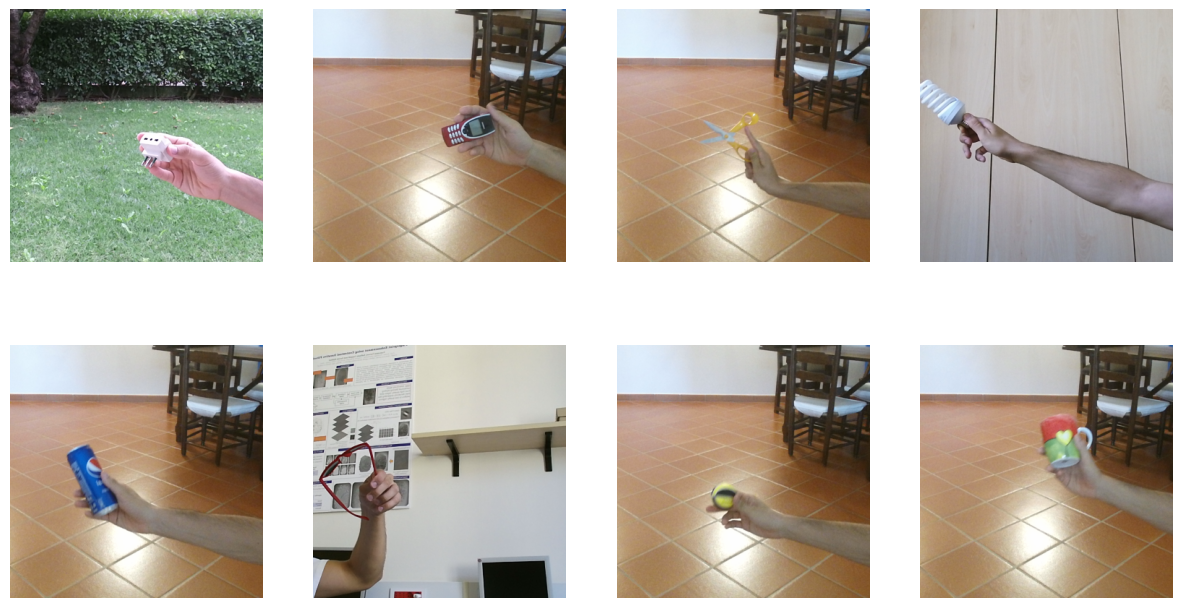

In [26]:
import os
from PIL import Image
import matplotlib.pyplot as plt

images = []
paths = []

fig, ax = plt.subplots(2, 4, figsize=(15, 8))
ax = ax.ravel()

for i in range(8):
    img_base_path = "/content/drive/MyDrive/aiunict-2023/train/0" + str(i) + "/"  # Update the path
    timages = os.listdir(img_base_path)  # List of images inside each subfolder
    images_path_to_display = os.path.join(img_base_path, timages[0])
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[i]
    ax[i].axis('off')
    ax[i].imshow(image, cmap='gray')

plt.show()


Orginal image

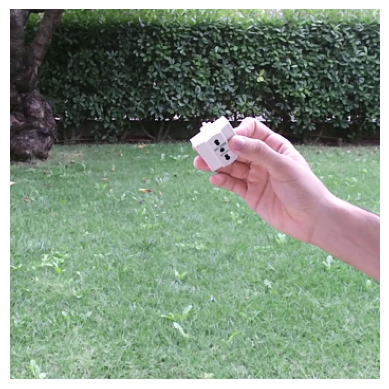

In [27]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Path of image
image_path = "/content/drive/MyDrive/aiunict-2023/train/00/00_015.png"

# Upload image using PIL 
image = Image.open(image_path)

# Transform to convert the image into a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# Converts the PyTorch tensor to a NumPy array
image_np = image_tensor.numpy()

# Transpose the array to fit the Matplotlib convention
image_np = image_np.transpose((1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.axis('off')  # Remove the axes
plt.show()

Orginal image with bouding box

/content/drive/MyDrive/aiunict-2023/train/00/00_000.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_004.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_005.png.jpg/content/drive/MyDrive/aiunict-2023/train/00/00_001.png.jpg

/content/drive/MyDrive/aiunict-2023/train/00/00_006.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_002.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_007.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_003.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_012.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_008.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_013.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_014.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_009.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_015.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_010.png.jpg
/content/drive/MyDrive/aiunict-2023/train/00/00_011.png.jpg


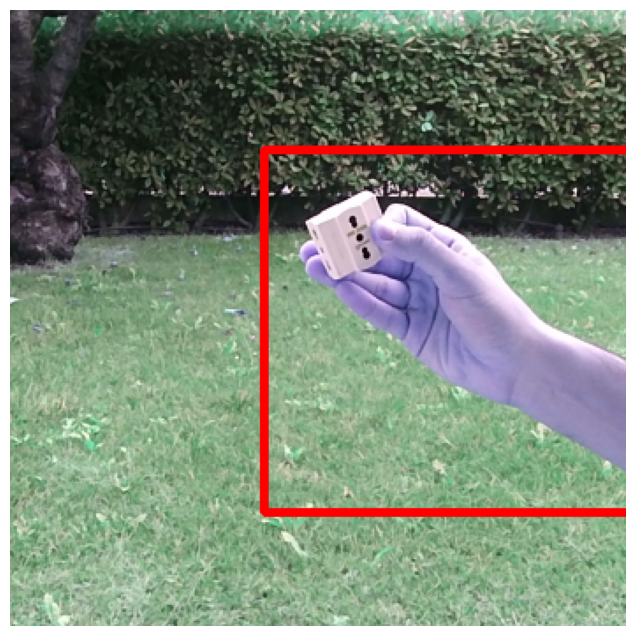

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

# Convert the array to the BGR color format expected by cv2.rectangle()
sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

Image Preprocessing

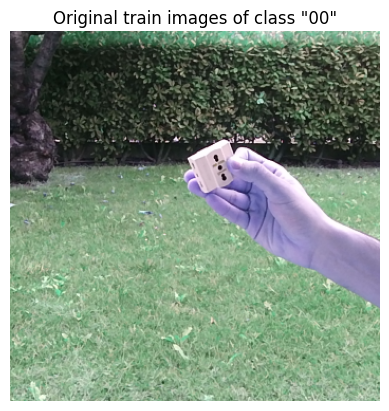

In [29]:
img = cv2.imread('/content/drive/MyDrive/aiunict-2023/train/00/00_000.png')
plt.axis('off')
plt.imshow(img)
plt.title('Original train images of class "00"')
plt.show()

RGB to HSV Scale

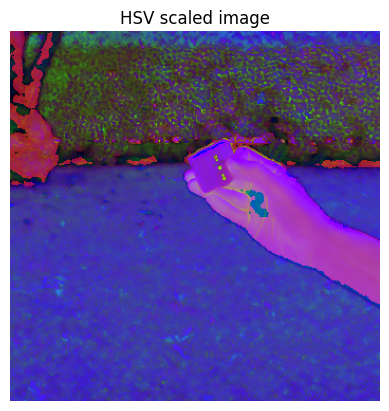

In [30]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.axis('off')
plt.imshow(hsv)
plt.title('HSV scaled image')
plt.show()

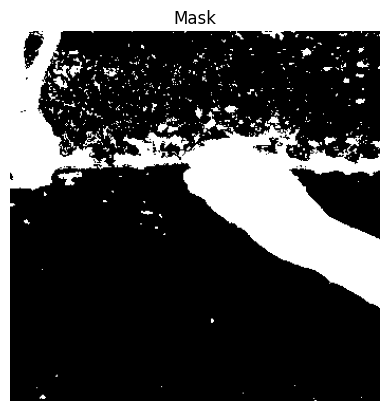

In [31]:
mask = cv2.inRange(hsv, (36, 25, 25), (89, 255,255))
mask = cv2.bitwise_not(mask)
plt.axis('off')
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

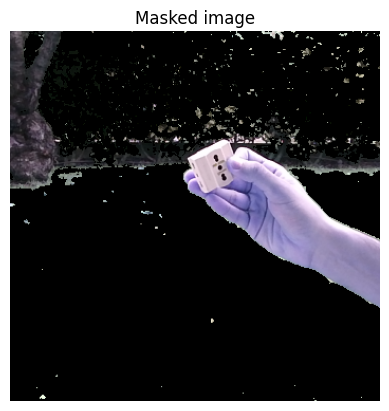

In [32]:
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]
plt.imshow(green)
plt.axis('off')
plt.title('Masked image')
plt.show()

Remove background

In [33]:
import cv2
import os
import numpy as np
from PIL import Image

def background_remove(img):
    img = np.asarray(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (36, 25, 25), (89, 255, 255))
    mask = cv2.bitwise_not(mask)
    imask = mask > 0
    green = np.zeros_like(img, np.uint8)
    green[imask] = img[imask]
    green = Image.fromarray(green)
    return green

input_folder = '/content/drive/MyDrive/aiunict-2023/train/00'  # Input folder containing images
output_folder = input_folder  # Output folder for edited images

# Make sure the output folder exists, otherwise create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List of files in the input folder
file_list = os.listdir(input_folder)

# Iterate over all files in the input folder
for file_name in file_list:
    # Create the full path to the input file
    input_path = os.path.join(input_folder, file_name)

    # Upload the input image
    img = cv2.imread(input_path)

    # Apply the background removal function
    processed_img = background_remove(img)

    # Create the full path to the output file
    output_path = os.path.join(output_folder, file_name)

    # Save the processed image in the output folder
    processed_img.save(output_path)

    print(f"Image '{file_name}' processed and saved to '{output_path}'")


Image '00_044.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_044.png'
Image '00_079.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_079.png'
Image '00_051.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_051.png'
Image '00_131.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_131.png'
Image '00_132.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_132.png'
Image '00_045.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_045.png'
Image '00_119.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_119.png'
Image '00_086.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_086.png'
Image '00_078.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_078.png'
Image '00_096.png' processed and saved to '/content/drive/MyDrive/aiunict-2023/train/00/00_096.png'


Crop train images given the bounding boxes and save them in the corresponding directory with the same directory structure as the input.

In [34]:
train_dir_crop = '/content/drive/MyDrive/aiunict-2023/train_crop'
test_dir_crop = '/content/drive/MyDrive/aiunict-2023/test_crop'

In [54]:
import os
import csv
from PIL import Image
import torch
import torchvision.transforms as transforms

# Function to crop an image given a bounding box
def crop_image(image, bbox):
    return image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

# Path to the input data directory
input_dir = '/content/drive/MyDrive/aiunict-2023/train'

# Uploading CSV file containing bounding box information
csv_file = '/content/drive/MyDrive/aiunict-2023/train.csv'

# Output directory path for cropped images
output_dir = '/content/drive/MyDrive/aiunict-2023/train_crop'

# Creating the output directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)

# Uploading CSV file containing bounding box information
with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header line
    for row in csv_reader:
        image_name = row[0]
        bbox = [int(val) for val in row[1:]]  # Convert coordinates to integers
        
        # Constructing the full path to the image
        image_path = os.path.join(input_dir, image_name)
        
        # Image upload using PIL
        image = Image.open(image_path)
        
        # Image cropping using the bounding box
        cropped_image = crop_image(image, bbox)
        
        # Saving the image in the corresponding output directory
        output_subdir = os.path.join(output_dir, os.path.dirname(image_name))
        os.makedirs(output_subdir, exist_ok=True)
        output_path = os.path.join(output_subdir, os.path.basename(image_name))
        cropped_image.save(output_path)

print("Cropping and saving completed.")

Cropping and saving completed.


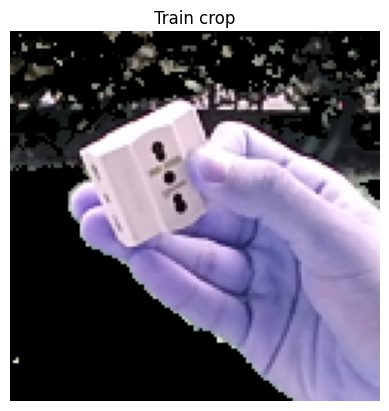

In [36]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Image path
image_path = "/content/drive/MyDrive/aiunict-2023/train_crop/00/00_000.png"

# Upload the image using PIL
image = Image.open(image_path)

# Transform to convert the image into a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# Converts the PyTorch tensor to a NumPy array
image_np = image_tensor.numpy()

# Transpose the array to fit the Matplotlib convention
image_np = image_np.transpose((1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.axis('off')  # Remove the axes
plt.title('Train crop')
plt.show()

Crop test images given the bounding boxes and save them in the corresponding directory with the same directory structure as the input.

In [55]:
import os
import csv
from PIL import Image
import torch
import torchvision.transforms as transforms

# Function to crop an image given a bounding box
def crop_image(image, bbox):
    return image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

# Path to the input data directory
input_dir_test = '/content/drive/MyDrive/aiunict-2023/test'

# Uploading CSV file containing bounding box information
csv_file_test = '/content/drive/MyDrive/aiunict-2023/test.csv'

# Output directory path for cropped images
output_dir = '/content/drive/MyDrive/aiunict-2023/test_crop'

# Creating the output directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)

# Uploading CSV file containing bounding box information
with open(csv_file_test, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header line
    for row in csv_reader:
        image_name = row[0]
        bbox = [int(val) for val in row[1:]]  # Convert coordinates to integers
        
        # Constructing the full path to the image
        image_path = os.path.join(input_dir_test, image_name)
        
        # Image upload using PIL
        image = Image.open(image_path)
        
        # Image cropping using the bounding box
        cropped_image = crop_image(image, bbox)
        
        # Saving the image in the corresponding output directory
        output_subdir = os.path.join(output_dir, os.path.dirname(image_name))
        os.makedirs(output_subdir, exist_ok=True)
        output_path = os.path.join(output_subdir, os.path.basename(image_name))
        cropped_image.save(output_path)

print("Cropping and saving completed.")

Cropping and saving completed.


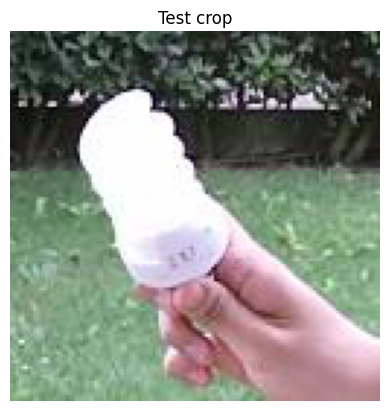

In [38]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Image path
image_path = "/content/drive/MyDrive/aiunict-2023/test_crop/000.jpg"

# Upload the image using PIL
image = Image.open(image_path)

# Transform to convert the image into a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# Converts the PyTorch tensor to a NumPy array
image_np = image_tensor.numpy()

# Transpose the array to fit the Matplotlib convention
image_np = image_np.transpose((1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.axis('off')  # Remove the axes
plt.title('Test crop')
plt.show()

Training

Step 1: Import Libraries

In [39]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step 2: Data Loader

In [40]:
train_dir_crop = '/content/drive/MyDrive/aiunict-2023/train_crop'
test_dir_crop = '/content/drive/MyDrive/aiunict-2023/test_crop'

In [41]:
# Data Transformer
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(),
    transforms.RandomInvert(),
    transforms.RandomSolarize(threshold=192.0),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [42]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the paths to the train and test directories
train_dir_crop = '/content/drive/MyDrive/aiunict-2023/train_crop'
test_dir_crop = '/content/drive/MyDrive/aiunict-2023/test_crop'

# Create the ImageFolder dataset for the train dataset
train_ds = ImageFolder(train_dir_crop, transform=train_tfm)

# Create a custom dataset for the test dataset
test_images = []
test_labels = []

# Iterate over the images in the test directory
for filename in os.listdir(test_dir_crop):
    # Construct the path to the image
    image_path = os.path.join(test_dir_crop, filename)
    # Load the image and apply transformations
    image = test_tfm(Image.open(image_path))
    # Add the image and assign a dummy label (0 in this case)
    test_images.append(image)
    test_labels.append(0)

# Convert the test images and labels to tensors
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

# Create a TensorDataset for the test dataset
test_ds = torch.utils.data.TensorDataset(test_images, test_labels)

In [43]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)

1600 800
{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7}


In [44]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

Define Resnet-18 model

In [45]:
# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=8)
model = model.to(device)
# model = model.cuda()    # only if your system supports Nvidia CUDA

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [46]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [47]:
for epoch in range(10):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 54/54 [00:14<00:00,  3.71batch/s]


Epoch: 0, Time: 0.2562282164891561, Loss: 0.09066856652498245
Train_acc: 0.845, Test_acc: 0.1125


100%|██████████| 54/54 [00:08<00:00,  6.39batch/s]


Epoch: 1, Time: 0.15481104056040446, Loss: 0.09522034972906113
Train_acc: 0.956875, Test_acc: 0.10625


100%|██████████| 54/54 [00:08<00:00,  6.40batch/s]


Epoch: 2, Time: 0.15432014067967734, Loss: 0.015610571019351482
Train_acc: 0.966875, Test_acc: 0.06375


100%|██████████| 54/54 [00:08<00:00,  6.31batch/s]


Epoch: 3, Time: 0.15635461807250978, Loss: 0.35384973883628845
Train_acc: 0.969375, Test_acc: 0.09625


100%|██████████| 54/54 [00:08<00:00,  6.17batch/s]


Epoch: 4, Time: 0.1598849654197693, Loss: 0.006401550956070423
Train_acc: 0.976875, Test_acc: 0.02375


100%|██████████| 54/54 [00:08<00:00,  6.44batch/s]


Epoch: 5, Time: 0.15402650038401286, Loss: 0.017675017938017845
Train_acc: 0.993125, Test_acc: 0.07


100%|██████████| 54/54 [00:08<00:00,  6.43batch/s]


Epoch: 6, Time: 0.1540892759958903, Loss: 0.005086720921099186
Train_acc: 0.990625, Test_acc: 0.0675


100%|██████████| 54/54 [00:08<00:00,  6.28batch/s]


Epoch: 7, Time: 0.15705717007319134, Loss: 0.4655332565307617
Train_acc: 0.988125, Test_acc: 0.03375


100%|██████████| 54/54 [00:08<00:00,  6.25batch/s]


Epoch: 8, Time: 0.15768954356511433, Loss: 0.015803128480911255
Train_acc: 0.97625, Test_acc: 0.0625


100%|██████████| 54/54 [00:08<00:00,  6.49batch/s]


Epoch: 9, Time: 0.15298138856887816, Loss: 0.026855815201997757
Train_acc: 0.9875, Test_acc: 0.0075


Model Performance Demonstration

In [48]:
# Index mapping for the dataframe

idx_to_class = {0: 'socket',
 1: 'phone',
 2: 'scissors',
 3: 'bulb',
 4: 'can',
 5: 'sunglasses',
 6: 'ball',
 7: 'cup'}

In [49]:
sample_image_1 = "/content/drive/MyDrive/aiunict-2023/test_crop/140.jpg"
sample_image_2 = "/content/drive/MyDrive/aiunict-2023/test_crop/001.jpg"
sample_image_3 = "/content/drive/MyDrive/aiunict-2023/test_crop/002.jpg"
sample_image_4 = "/content/drive/MyDrive/aiunict-2023/test_crop/003.jpg"

sample_list = [sample_image_1, sample_image_2, sample_image_3, sample_image_4]

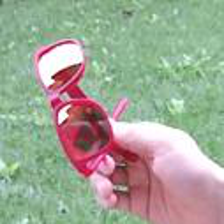

sunglasses


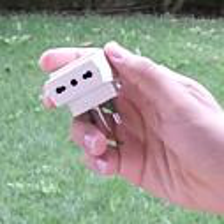

phone


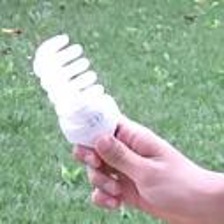

bulb


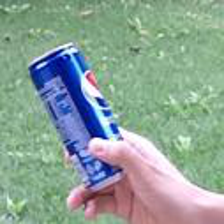

can


In [50]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = test_tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    print(idx_to_class[pred])
    print("====================================")

Execution of the prediction and save in a CSV file

In [51]:
import os
import csv
from PIL import Image
import torch
import torchvision.transforms as transforms

# Device definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get list of image files in test folder
def get_image_list(folder_path):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                image_list.append(os.path.join(root, file))
    return image_list

# Predict images and save the results in a CSV file
def predict_images(image_list, model, idx_to_class):
    predictions = []
    for img_path in image_list:
        img = Image.open(img_path)
        img_tensor = test_tfm(img)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.to(device)
        prob = model(img_tensor)
        pred = torch.max(prob, 1).indices
        pred = pred.item()
        predictions.append(pred)

    # Saving of results in a CSV file
    with open('predictions.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image', 'class'])
        for i, img_path in enumerate(image_list):
            image_name = os.path.basename(img_path)
            pred = predictions[i]  # We get the current prediction
            class_name = idx_to_class.get(pred)  # We get the name of the class corresponding to the predicted index
            writer.writerow([image_name, pred])

# Execution of the prediction
test_folder = "/content/drive/MyDrive/aiunict-2023/test_crop"
image_list = get_image_list(test_folder)
predict_images(image_list, model, idx_to_class)


Grad-CAM

The purpose of this code is to load a pre-trained ResNet-18 model, perform image classification on a test image, and generate the Guided Grad-CAM (Gradient-weighted Class Activation Mapping) visualization for the predicted class.

In [52]:
!pip install captum --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


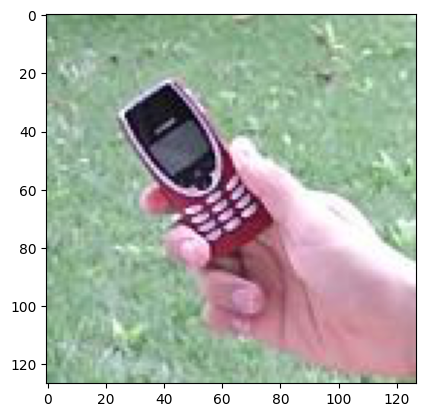

Predicted:( 0.739088237285614 )
torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


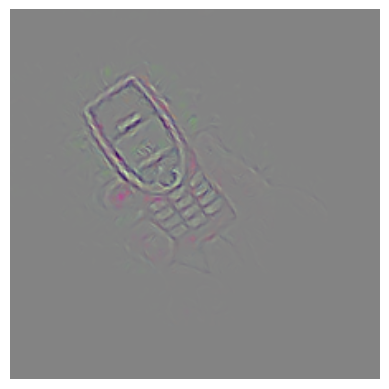

In [53]:
#load a pretrained model
from torchvision.models import resnet18
import torch
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model = resnet18(pretrained=True).to('cuda')
model = model.eval()

test_img = Image.open('/content/drive/MyDrive/aiunict-2023/test_crop/023.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

# model expects 224x224 3-color image
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0).to('cuda') # the model requires a dummy batch dimension

labels_path = '/content/drive/MyDrive/imagenet-simple-labels.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

output = model(input_img)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:' '(', prediction_score.squeeze().item(), ')')

from captum.attr import GuidedGradCam

gg = GuidedGradCam(model, model.layer4)
input_img.requires_grad_()
gg_attr = gg.attribute(input_img, pred_label_idx.item())
print(gg_attr.shape)

gg_attr_np = np.transpose(gg_attr[0].detach().cpu().numpy(), (1, 2, 0))
gg_attr_np = (gg_attr_np - gg_attr_np.min()) / (gg_attr_np.max() - gg_attr_np.min())
plt.imshow(gg_attr_np, cmap='hot', interpolation='bilinear', vmin=0, vmax=1)
plt.axis('off')
plt.show()